#Created on Wed Feb, 23 2022

#@author: Sangyu Xu

This notebook illustrates the usage of EspressoLocomotion012022, version no. 0.1.4
Version change: 

## Version notes 0.1.4: 


* setfont bug fix

* moved colorbar on heatmap to bottom

* small multiples bug fix

* changed bounded lines ylim input



In [10]:
import os
homepath = os.environ.get('HOMEPATH')
# add 'espressoLocomotion' code to path so that we can import it.
import sys
sys.path.append(os.path.join(homepath, 'Documents', 'GitHub', 'SangyuTest', 'EspressoLocomotion012022'))
sys.path.append(os.path.join(homepath, 'Documents', 'GitHub', 'Tools'))


In [1]:

import EspressoLocomotion012022
import matplotlib.pyplot as plt
# the line below let's you render text as text instead of path when you export svgs
plt.rcParams['svg.fonttype'] = 'none'
import matplotlib
%matplotlib inline
import numpy as np
import locoDataMunger012022
import locoUtilities
import pandas as pd
import locoPlotters082021
import espresso as esp
import dabest
import os
import seaborn as sns
from importlib import reload
import plotTools
from setFont import setFont
from plotTools import savePlots
from plotTools import saveDabestData
from plotTools import plotContrasts
cm = 1/2.54
setFont('Inter', 10)

import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)


def createEspressoPalette(df, paletteColors):
    # Set up a custom palette for plots
    import seaborn as sns
    CPalette = esp.create_palette(paletteColors, # green for test, use this for ACR expriments
                                np.unique(df.Genotype)
                                )
    sns.palplot(CPalette.values())
    print(np.unique(df.Genotype))
    return CPalette 





# find the MB113C>CsCh data and make a folder for the pictures you are about to dump, if, after checking, there is no existing "images" folder


MB113CPath='/Users/xusy/Data/trhcsch1'

MB113CImagePath=MB113CPath+ '/images/'
mainDataPathList=os.listdir(MB113CPath)
if [s for s in mainDataPathList if 'images' in s]==[]:
    os.mkdir(MB113CImagePath)
    




In [2]:
# load feeding data
MB113CFeeds = esp.espresso(MB113CPath, expt_duration_minutes=60)
    
startHour=0
endHour=24#hours
MB113CFilePrefix = MB113CImagePath + str(startHour)+ 'to' + str(endHour) + '_'



/Users/xusy/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


countLog files found: 

['CountLog_2019-04-29_14-47-30.csv' 'CountLog_2019-05-01_14-57-57.csv']

metaData files found: 

['MetaData_2019-04-29_14-47-30.csv' 'MetaData_2019-04-29_14-47-32.csv'
 'MetaData_2019-05-01_14-57-57.csv' 'MetaData_2019-05-01_14-57-59.csv']
portLocations files found: 

['PortLocations_2019-04-29_14-47-32.csv'
 'PortLocations_2019-05-01_14-57-59.csv']

feedLog files found: 

['FeedLog_2019-04-29_14-47-32.csv' 'FeedLog_2019-05-01_14-57-59.csv']
CountLog_2019-04-29_14-47-30.csv
MetaData_2019-04-29_14-47-30.csv
CountLog_2019-05-01_14-57-57.csv
MetaData_2019-05-01_14-57-57.csv
['trh-gal4>uas-chrimson' 'w1118; trh-gal4' 'w1118; uas-chrimson']


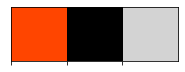

In [3]:
# load locomotion data
MB113CLoco = EspressoLocomotion012022.EspressoLocomotion012022(MB113CPath, 0, 120, companionEspObj = MB113CFeeds)

# locomotion stuff gets its own palette because the two analysis processes don't turn everything to small letters at the same stage
 
MB113CLocoPalette = createEspressoPalette(MB113CLoco.resultsDf, [ 'orangered', 'k',  'lightgray'])

# this is so that we can use the same xlabels for the contrast plotting function later
MB113CLoco.resultsDf['CombinedGroupBy'] = MB113CLoco.resultsDf['Temperature']+'; '+ MB113CLoco.resultsDf['Status']
MB113CXlabels = np.unique(MB113CLoco.resultsDf['CombinedGroupBy'])


In [4]:

# Here i define an overarching function for plotting time series with bounded line CI. all the numbers can be changed 
# it also sets the offspring to light color and light off to dashed lines

textFontSize = 8
legendKwargsTSTransgenic = {"loc": 'lower left',
                         "fontsize": textFontSize-1, 
                         "edgecolor": 'w', 
                       'handletextpad':0.02,
                        'labelspacing': 0.1,
                  'bbox_to_anchor': (0.8*cm, 1.1*cm)
                           }

def plotFormattedTSTransgenic(locoObj,TSTransgenicMetricMapDf, metric, legendKwargsTSTransgenic, prefix):
    entry = TSTransgenicMetricMapDf.loc[TSTransgenicMetricMapDf.metric ==metric]
    exptName = prefix+ 'TS_2hr'
    filename = exptName + '_' + metric
    TempPalette = {'25': 'gray', '25': sns.desaturate('orangered', desatProp)}
    TS,  TSAxes, TSMeanLines, TSCiBounds = locoObj.plotBoundedLines(colorBy = 'Temperature', col = 'Status', rp = '600s', YLim = entry.YLim.iloc[0], customPalette = TempPalette, locoSuffix = metric)
    setFont('Source Sans Pro', textFontSize)
    lightOnColor = sns.desaturate('orangered', desatProp)
    TSMeanLines[0].set_color('k')
    TSMeanLines[0].set_linestyle('--')
    TSMeanLines[1].set_color('k')
    TSMeanLines[2].set_color(lightOnColor)
    TSMeanLines[2].set_linestyle('--')
    TSMeanLines[3].set_color(lightOnColor)
    TSCiBounds[0].set_edgecolor('lightgray')
    TSCiBounds[0].set_facecolor('lightgray')
    TSCiBounds[1].set_edgecolor('k')
    TSCiBounds[1].set_facecolor('gray')
    TSCiBounds[2].set_edgecolor(lightOnColor)
    TSCiBounds[2].set_facecolor(lightOnColor)
    TSCiBounds[2].set_alpha(0.07)
    TSCiBounds[3].set_edgecolor(lightOnColor)
    TSCiBounds[3].set_facecolor(lightOnColor)
    TSCiBounds[3].set_alpha(0.3)
    TSAxes[0, 0].legend(['Off', 'On'], fontsize = textFontSize+3)
    TSAxes[0, 1].legend(['Off', 'On'], fontsize = textFontSize+3)
    setFont('Source Sans Pro', 16)
    TSAxes[0, 0].set_ylabel(entry.y.iloc[0], fontsize = textFontSize+5)
    TSAxes[0, 1].set_xlabel('Time (Min)', fontsize = textFontSize+5, labelpad = 0.05)
    TSAxes[0, 0].set_xlabel('Time (Min)', fontsize = textFontSize+5, labelpad = 0.05)
    TS.savefig(MB113CFilePrefix + metric+'BoundedLineEdited' +'.png',transparent=True, bbox_inches='tight', dpi=fDPI)
    TS.savefig(MB113CFilePrefix + metric+'BoundedLineEdited' +'.svg',transparent=True, bbox_inches='tight')
    TS.set_size_inches(12*cm, 6*cm)
    savePlots(TS, filename)
    return TS,  TSAxes, TSMeanLines, TSCiBounds




0     Ctrl
1     Ctrl
2     Ctrl
3     Ctrl
4     Ctrl
5     Ctrl
6     Ctrl
7     Ctrl
8     Ctrl
9     Ctrl
10    Ctrl
11    Ctrl
12    Ctrl
13    Ctrl
14    Ctrl
15    Ctrl
16    Ctrl
17    Ctrl
18    Ctrl
19    Ctrl
20    Ctrl
21    Test
22    Test
23    Test
24    Test
25    Test
26    Test
27    Test
28    Test
29    Test
30    Ctrl
31    Ctrl
32    Ctrl
33    Ctrl
34    Ctrl
35    Ctrl
36    Ctrl
37    Ctrl
38    Ctrl
39    Ctrl
40    Ctrl
41    Ctrl
42    Ctrl
43    Ctrl
44    Ctrl
45    Ctrl
46    Ctrl
47    Ctrl
48    Ctrl
49    Ctrl
50    Test
51    Test
52    Test
53    Test
54    Test
55    Test
56    Test
57    Test
58    Test
59    Test
Name: Status_x, dtype: object
['Red Light Off; Ctrl' 'Red Light Off; Test' 'Red Light On; Ctrl'
 'Red Light On; Test']
['trh-gal4>uas-cschrimson' 'w1118; trh-gal4' 'w1118; uas-cschrimson']


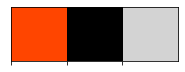

In [6]:
# this is was here because for food choice i need organize the feeds by certain criteria. can ignore can calculate as you like
def calculateMealSize(esp, groupby1 = 'Temperature', groupby2 = 'Sex', compareby = 'Status'):
    xx = esp.plot.contrast.feed_volume_per_fly(group_by=groupby1, compare_by=compareby)
    yy = esp.plot.contrast.feed_volume_per_fly(group_by=groupby2, compare_by=compareby)
    xx.mean_diff._plot_data['Status'] =  xx.mean_diff._plot_data.Status.replace({'Sibling': 'Ctrl', 'Offspring': 'Test'})
    yy.mean_diff._plot_data['Status'] =  yy.mean_diff._plot_data.Status.replace({'Sibling': 'Ctrl', 'Offspring': 'Test'})
    
    x=xx.mean_diff._plot_data.rename(columns={"plot_groups": "Sex", "plot_groups_with_contrast": "CombinedGroupBy"})
    y=yy.mean_diff._plot_data
    espSplit=pd.merge(x, y, on="ChamberID")
    print(espSplit.Status_x)
    espSplit['MealSize']= espSplit['Total\nFeed Volume\nPer Fly (nl)_y']/espSplit['Total\nFeed Count\nPer Fly_y']
    temps = np.unique(espSplit.Temperature)
    espSplit['CombinedGroupBy'] =  espSplit['CombinedGroupBy'].replace({temps[0]+'; Sibling': temps[0]+'; Ctrl', temps[0]+'; Offspring': temps[0]+'; Test'})
    espSplit['CombinedGroupBy'] =  espSplit['CombinedGroupBy'].replace({temps[1]+'; Sibling': temps[1]+'; Ctrl', temps[1]+'; Offspring': temps[1]+'; Test'})

    # zf=z.loc[z.Sex=='F']  
    # zm=z.loc[z.Sex=='M']
    xlabels=np.sort(np.unique(espSplit['CombinedGroupBy']))
    print(xlabels)
    return espSplit, xlabels

MB113CSplit, xlabels = calculateMealSize(MB113CFeeds)
MB113CSplit.rename(columns = {'Genotype_x':'Genotype'}, inplace = True)
MB113CSplit['MealSize'] = MB113CSplit['MealSize'].fillna(0)
MB113CSplit["Genotype"] = MB113CSplit["Genotype"].str.lower()
MB113CSplit['Genotype'] = MB113CSplit['Genotype'].str.replace('-chrimson', '-cschrimson')


MB113CPalette = createEspressoPalette(MB113CSplit, [ 'orangered', 'k',  'lightgray'])



# Experiment Summary

The espressoLocomotion object contains a summary of the experiments. Each line is one run of espresso

In [8]:
MB113CLoco.experimentSummary

,countLogFile,countLogDate,metaDataFile,metaDataDate,portLocationsFile,portLocationsDate,feedLogFile,feedLogDate
0,CountLog_2019-04-29_14-47-30.csv,2019-04-29_14-47-30,MetaData_2019-04-29_14-47-30.csv,2019-04-29_14-47-30,PortLocations_2019-04-29_14-47-32.csv,2019-04-29_14-47-32,FeedLog_2019-04-29_14-47-32.csv,2019-04-29_14-47-32
1,CountLog_2019-05-01_14-57-57.csv,2019-05-01_14-57-57,MetaData_2019-05-01_14-57-57.csv,2019-05-01_14-57-57,PortLocations_2019-05-01_14-57-59.csv,2019-05-01_14-57-59,FeedLog_2019-05-01_14-57-59.csv,2019-05-01_14-57-59


# Heatmaps for locomotion 
plotMeanHeatMaps(self, binSize = 0.2, row = None, col = None, reverseRows = False, reverseCols = False,  verbose = False, heatmapCMap = 'RdYlBu_r', smooth = 2)

binSize:  size of the 2D bins in mm

smooth: the extent of gaussian smoothing in std

row: the independent factor whose values will be used to populate rows, e.g. 'Temperature'

col: the independent factor whose values will be used to populate columns, e.g. 'Status'

heatmapCMap: colormap for the heatmap

reverseRows: if True reversed the order of the row values

reverseCols: if True reversed the order of the col values

verbose: if True plots individual heatmaps



<Figure size 360x748.8 with 0 Axes>

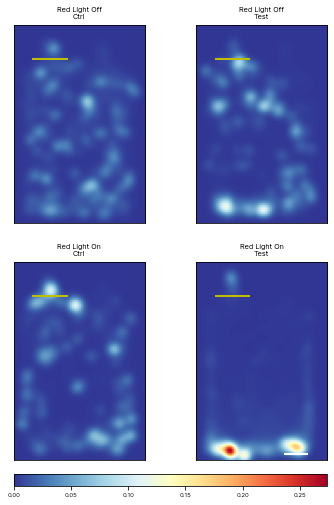

In [18]:

MB113CLoco.plotMeanHeatMaps(binSize = 0.2, smooth = 2, row = 'Temperature', col = 'Status', reverseCols = True, heatmapCMap = 'RdYlBu_r')



This function stores meanHeatmapFig and heatmapImages into espressoLocomotion object which can be used to retrieve these objects. You can alter the heatmap as follows:

In [19]:
# since most of the metrics and conditions have long and cumbersome names, here I edit 
# them by accessing the heatmap handle provided by EspressoLocomotion.plotMeanHeatMaps
setFont('Inter', 6)


MB113CLoco.meanHeatmapFig.axes[0].set_title('Ctrl', fontsize='xx-large', fontweight = 'regular')
MB113CLoco.meanHeatmapFig.axes[1].set_title('Test', fontsize='xx-large', fontweight = 'regular')
MB113CLoco.meanHeatmapFig.axes[2].set_title('')
MB113CLoco.meanHeatmapFig.axes[3].set_title('')

MB113CLoco.meanHeatmapFig.axes[0].set_ylabel('Light Off', fontsize='xx-large', fontweight = 'regular')
MB113CLoco.meanHeatmapFig.axes[2].set_ylabel('Light On', fontsize='xx-large', fontweight = 'regular')

MB113CLoco.meanHeatmapFig.axes[-1].remove()
MB113CLoco.meanHeatmapFig.add_axes([MB113CLoco.meanHeatmapFig.axes[-1].get_position().x1+0.05, MB113CLoco.meanHeatmapFig.axes[-1].get_position().y0, 0.02, MB113CLoco.meanHeatmapFig.axes[-1].get_position().y1-MB113CLoco.meanHeatmapFig.axes[-1].get_position().y0])
MB113CLoco.meanHeatmapFig.colorbar(MB113CLoco.heatmapImages[1], cax = MB113CLoco.meanHeatmapFig.axes[-1], orientation = 'vertical')

MB113CLoco.meanHeatmapFig.set_size_inches(6*cm, 10*cm)
MB113CLoco.meanHeatmapFig.suptitle('c', x = -0.0001, y = 0.96, horizontalalignment='left', verticalalignment='top', fontsize = 20, fontname="Inter", fontweight = 'semibold')

savePlots(MB113CLoco.meanHeatmapFig, MB113CFilePrefix+'_HeatMaps', 'fig1a')





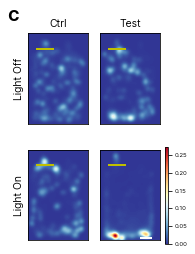

In [20]:
MB113CLoco.meanHeatmapFig



# Small Multiples for traces and heatmaps in individual chambers

plotChamberSmallMultiples(self, ncol = 15, customPalette = None, setNumber = None)




ncol:  number of columns in which to arrange the small multiples

customPalette: dictionary for the colors for plotting


setNumber: no of set to plot (0 for the first experiment, 1 for the second etc). When is None, all are plotted. 


Espresso Runs found:

['2019-04-29_14-47-30' '2019-05-01_14-57-57']


 plotting 2019-04-29_14-47-30...


 plotting 2019-05-01_14-57-57...


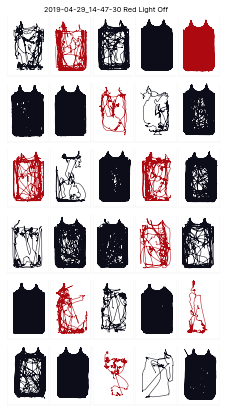

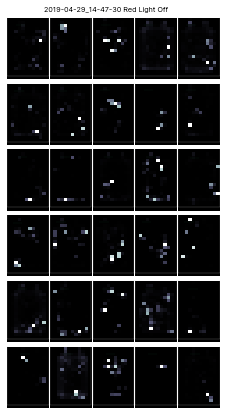

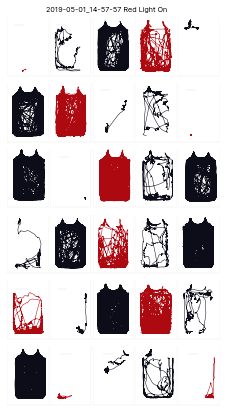

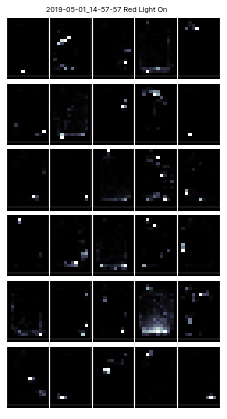

In [22]:
chamberSmallsTrack, axarrT, chamberSmallsHeat, axarrH = MB113CLoco.plotChamberSmallMultiples(ncol = 5)



Espresso Runs found:

['2019-04-29_14-47-30' '2019-05-01_14-57-57']


 plotting 2019-05-01_14-57-57...


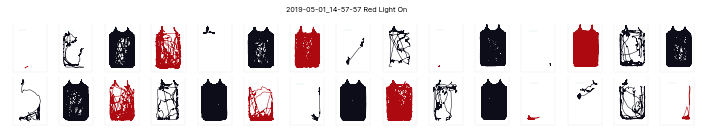

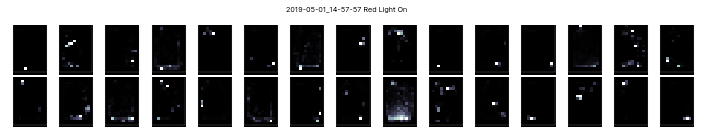

In [23]:
chamberSmallsTrack, axarrT, chamberSmallsHeat, axarrH = MB113CLoco.plotChamberSmallMultiples(setNumber = 1)




This function stores chamberSmallsTrack, axarrT, chamberSmallsHeat, axarrH into espressoLocomotion object which can be used to retrieve these objects

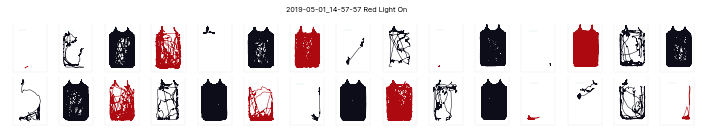

In [24]:
MB113CLoco.chamberSmallsTrack[0]

# Example Figure Panel:


First we define the arrangement of the independent variables on the x axis for the contrast plot:

In [80]:
MB113CXlabelsArr = ((MB113CXlabels[0], MB113CXlabels[2]), (MB113CXlabels[1], MB113CXlabels[3]))
print(MB113CXlabelsArr)



(('Red Light Off; Ctrl', 'Red Light On; Ctrl'), ('Red Light Off; Test', 'Red Light On; Test'))


## Contrast Plots 


Below we write a function that defines all the attributes of the contrast plot

In [88]:
figSize=(5.5*cm, 5*cm)
desatProp = 0.75
swarmMarkerSize = 2
ESMarkerSize = 4
contrastPlotKwargs4Columns = {'swarm_desat' : desatProp,
                        'raw_marker_size': swarmMarkerSize, 
                        'es_marker_size': ESMarkerSize,
                        'fig_size': figSize,
                        'group_summary_kwargs':{'lw':1}
                     }
legendKwargs4Columns = {"loc": 'lower left',
                         "bbox_transform": plt.gcf().transFigure, 
                         "fontsize": 9, 
                         "edgecolor": 'w', 
                       'handletextpad':0.02,
                        'labelspacing': 0.1          
                       }



def plotContrast4Columns(df, metricMapDf, metric, xlabelsArr, contrastPlotKwargs4Columns, legendKwargs4Columns, prefix, toAnnotate = True, Cpalette = MB113CLocoPalette, figureID = ''):
    textFontSize = 9
    from setFont import setFont
    setFont('Inter',textFontSize)

    entry = metricMapDf.loc[metricMapDf.metric ==metric]
    exptName = prefix+ 'Contrast_2hr'
    exptDataSource = MB113CPath
    filename = exptName + '_' + metric

    contrast = dabest.load(df,
                           x='CombinedGroupBy', # the default for this test config is to group flies by genotype
                           y=entry.y.iloc[0],
                            idx=tuple(xlabelsArr),
                           paired=False
#                             paired=False,
                          )

    f = contrast.mean_diff.plot(**contrastPlotKwargs4Columns,
                            swarm_label=entry.swarmLabel.iloc[0],                            
                            contrast_label='Mean Diff',
    #                         swarm_ylim=(-20, 600),
    #                         contrast_ylim=(-20, 200),
                            color_col = 'Genotype', 
                            custom_palette = Cpalette)
    contrastYlim = f.axes[1].get_ylim()[1]


    f = contrast.mean_diff.plot(**contrastPlotKwargs4Columns,
                            swarm_label=entry.swarmLabel.iloc[0],                            
                            contrast_label='Mean Diff',
    #                         swarm_ylim=(-20, 600),
#                             contrast_ylim=(-contrastYlim*0.05, contrastYlim),
                            color_col = 'Genotype', 
                            custom_palette = Cpalette)

    swarmYlim = f.axes[0].get_ylim()[1]
    f.axes[0].set_ylabel(entry.swarmLabel.iloc[0])

    f.axes[1].set_ylabel('Mean Diff')

    f.axes[1].collections[1].set_fc(sns.desaturate([value for key, value in Cpalette.items() if '>' in key.lower()][0]
    , 0.75))


    topLevel1 = swarmYlim*1.05

    topLevel2 = swarmYlim
    if toAnnotate:

        f.axes[0].set_xticklabels(['Off', 'On', 'Off','On'])
        f.axes[1].set_xticklabels(['','Ctrl On - Off', '', 'Test On - Off'])

#         f.axes[0].text(0.5, topLevel1, 'Sibling', ha = 'center')
#         f.axes[0].text(2.5, topLevel1, 'Offspring', ha = 'center')

#         f.axes[0].plot([0, 1], [topLevel2, topLevel2], 'k')
#         f.axes[0].plot([2, 3], [topLevel2, topLevel2], 'k')

    lg = f.axes[0].legend(bbox_to_anchor=(0.2*cm, 1.15*cm), **legendKwargs4Columns)

    lg.legendHandles[0]._sizes = [swarmMarkerSize+2]
    lg.legendHandles[1]._sizes = [swarmMarkerSize+2]
    lg.legendHandles[2]._sizes = [swarmMarkerSize+2]
    f.suptitle(figureID[-1], x=-0.15, y=1.2, horizontalalignment='left', verticalalignment='top', fontsize = 20, fontname="Inter")

#     f.tight_layout()


    savePlots(f, filename, figureID)
    summaryResults=saveDabestData(contrast, filename, exptDataSource, figureID, entry.yUnit.iloc[0])
    
    
    return f, contrast, summaryResults

<Figure size 432x288 with 0 Axes>

The above function plots a 4 column contrast plot. The xlabelsArr variable we stored earlier lets us arrange the dabest comparisons. 

The function also returns:
1. the contrast figure
2. the contrast object
3. a table of summary stats


this can be done for metrics such as 'Volume', 'Count' etc in 'MB113CSplit' and 'V' and 'Y' etc in 'MB113CLoco.resultsDf', as defined by the dataframes in the cell below. You can modify or add entries. 

In [119]:

# here i made a look up table for the various metric we want to plot. so that one function fits all

feedMetricMap = {'metric': ['Volume', 'Count', 'MealSize', 'Duration', 'Latency'], 
             'y' : ['Total\nFeed Volume\nPer Fly (nl)_y', 'Total\nFeed Count\nPer Fly_y', 'MealSize', 'Total Time\nFeeding\nPer Fly (min)_x', 'Latency to\nFirst Feed (min)_y'], 
             'swarmLabel': ['Volume (nL)', 'Count', 'MealSize (nL)', 'Duration (min)', 'Latency (min)'],
                'yUnit': ['nL', '', 'nL', 'min', 'min']}
feedMetricMapDf = pd.DataFrame(data = feedMetricMap)
 


locoMetricMap = {'metric': ['V', 'Y', 'InLeftPort', 'InRightPort', 'falls'], 
             'y' : ['averageSpeed_mm/s', 'yPosition_mm', 'inLeftPort', 'inRightPort', 'falls'], 
             'swarmLabel': ['Speed (mm/s)', 'Y-Position \n(mm/s)', 
                            'Percent Time Spent \nin Food Port', 'Percent Time Spent \nin Control Port', 'Number of Falls'],
            'yUnit' : ['mm/s', 'mm', '%', '%', '']
                }


locoMetricMapDf = pd.DataFrame(data = locoMetricMap)





monitorWindow = 120


periMetricMap = {'metric': ['DuringRatio', 'AfterRatio','PercDuring', 'PercAfter', 'TotalFeedDuration'], 
             'y' : ['duringBeforeSpeedRatio', 'afterBeforeSpeedRatio',str(monitorWindow)+'duringPercSpeedGain_Mean', str(monitorWindow)+'afterPercSpeedGain_Mean', 'revisedFeedDuration_s_Total'], 
             'swarmLabel': ['Ratio$_{ During, Before}$', 'Ratio$_{ After, Before}$','Percent Speed Change \nDuring Feed', 'Percent Speed Change \nAfter Feed', 'Total Feed Duration (s)'], 
                'yUnit': ['', '', '%', '%', 'Seconds']}
periMetricMapDf = pd.DataFrame(data = periMetricMap)











Run the code below to plot 1 panel. The panel number is automatially added. When figureID is given, such as 'Fig1a', it is used to add an identifier to the file name and also add a panel label on the top left corner of the plot. 

/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "w_pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent

Saving stats to /Users/xusy/Data/trhcsch1/images/0to24_Contrast_2hr_VolumeFig1aES_Sentences.txt

Fig1a


Bootstrap 1
Test group ("Red Light On; Ctrl", sample size 20) is higher than control group ("Red Light Off; Ctrl", sample size 21) by 22.01 nL (95% CI = [-40.99, 90.9] nL, p-value = 0.478, g = 0.2).
Hypothesis test used is mann whitney.

Hedge's g for this comparison is 0.2 (95% CI = [-0.41, 0.88] nL).


Bootstrap 2
Test group ("Red Light On; Test", sample size 10) is lower than control group ("Red Light Off; Test", sample size 9) by 161.46 nL (95% CI = [-231.25, -75.08] nL, p-value = 0.003, g = -1.76).
Hypothesis test used is mann whitney.

Hedge's g for this comparison is -1.76 (95% CI = [-3.35, -0.73] nL).




/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


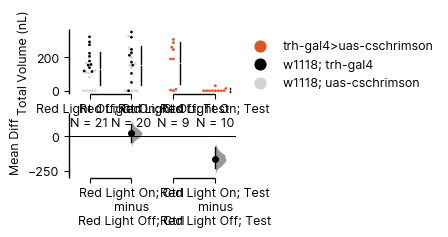

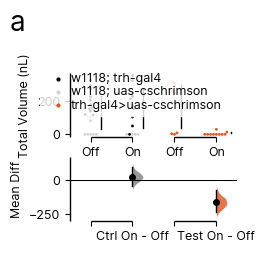

In [89]:


fig1a, contrast1a, summaryResults1a = plotContrast4Columns(MB113CSplit, feedMetricMapDf, 'Volume', MB113CXlabelsArr, contrastPlotKwargs4Columns, legendKwargs4Columns, MB113CFilePrefix, toAnnotate = True, Cpalette = MB113CPalette, figureID = 'Fig1a')

## here the alignment of the legend box is decided according to what it looks like in the svg. am trying to figure out how to make eveyrthing look the same

# Figure time course 



Simply run the plotBoundedLines method from espressoLocomotion 

(<Figure size 432x216 with 2 Axes>,
 array([[<AxesSubplot:title={'center':'  Ctrl'}, ylabel='Average Speed (mm/s)'>,
         <AxesSubplot:title={'center':'  Test'}>]], dtype=object),
  <matplotlib.collections.PolyCollection at 0x7ff3153a8610>])

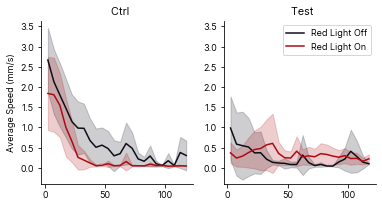

In [95]:
MB113CLoco.plotBoundedLines(colorBy = 'Temperature', col = 'Status', reverseCol= True)

or use the wrapper function below:

In [104]:

def plotFormattedTSTransgenic(locoObj,TSTransgenicMetricMapDf, metric, legendKwargsTSTransgenic, prefix, figureID = ''):
    from setFont import setFont
    textFontSize = 9
    setFont('Inter', textFontSize)
    entry = TSTransgenicMetricMapDf.loc[TSTransgenicMetricMapDf.metric ==metric]
    exptName = prefix+ 'TS_2hr'
    filename = exptName + '_' + metric
    TempPalette = {'Red Light Off': 'gray', 'Red Light On': sns.desaturate('orangered', desatProp)}
    TS,  TSAxes, TSMeanLines, TSCiBounds = locoObj.plotBoundedLines(colorBy = 'Temperature', col = 'Status', rp = '100s', reverseCol = True, YLim = entry.YLim.iloc[0], customPalette = TempPalette, locoSuffix = metric)
    setFont('Inter', textFontSize)
    lightOnColor = sns.desaturate('orangered', desatProp)
    TSMeanLines[0].set_color('k')
    TSMeanLines[0].set_linestyle('--')
    TSMeanLines[1].set_color('k')
    TSMeanLines[2].set_color(lightOnColor)
    TSMeanLines[2].set_linestyle('--')
    TSMeanLines[3].set_color(lightOnColor)
    TSCiBounds[0].set_edgecolor('lightgray')
    TSCiBounds[0].set_facecolor('lightgray')
    TSCiBounds[1].set_edgecolor('k')
    TSCiBounds[1].set_facecolor('gray')
    TSCiBounds[2].set_edgecolor(lightOnColor)
    TSCiBounds[2].set_facecolor(lightOnColor)
    TSCiBounds[2].set_alpha(0.07)
    TSCiBounds[3].set_edgecolor(lightOnColor)
    TSCiBounds[3].set_facecolor(lightOnColor)
    TSCiBounds[3].set_alpha(0.3)

    TSAxes[0, 0].legend(['Off', 'On'], fontsize = textFontSize-2)
    TSAxes[0, 1].legend(['Off', 'On'], fontsize = textFontSize-2)

    TSAxes[0, 0].set_ylabel(entry.y.iloc[0], fontsize = textFontSize)
    TSAxes[0, 1].set_xlabel('Time (Min)', fontsize = textFontSize, labelpad = 0.05)
    TSAxes[0, 0].set_xlabel('Time (Min)', fontsize = textFontSize, labelpad = 0.05)

    TS.suptitle(figureID[-1], x=-0.05, y=1.05, horizontalalignment='left', verticalalignment='top', fontsize = 20, fontname="Inter ExtraBold")
    
    TS.savefig(prefix + metric+'BoundedLineEdited' +'.png',transparent=True, bbox_inches='tight', dpi=fDPI)
    TS.savefig(prefix + metric+'BoundedLineEdited' +'.svg',transparent=True, bbox_inches='tight')

    
    TS.set_size_inches(7.5*cm, 3.5*cm)
    savePlots(TS, filename, figureID)
    return TS,  TSAxes, TSMeanLines, TSCiBounds




Time course plots can be made for the following metrics

In [108]:


# TSTransgenicMetricMap = {'metric': ['V', 'Y', 'InLeftPort', 'InRightPort'], 
#              'y' : ['Speed(mm/s)', 'Y-Position(mm)', 'Percent Time \nin Food Port', 'Percent Time \nin Control Port'],
#               'YLim': [[0, 2.5], [0, 12], [0, 14], [0, 14]]}

TSTransgenicMetricMap = {'metric': ['V', 'Y', 'InLeftPort', 'InRightPort'], 
             'y' : ['Speed(mm/s)', 'Y-Position(mm)', 'Percent Time \nin Food Port', 'Percent Time \nin Control Port'],
              'YLim': [[], [], [], []]}

TSTransgenicMetricMapDf = pd.DataFrame(data = TSTransgenicMetricMap)




/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "w_pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "h_pad" which is no longer supported as of 3.3 and will become an error two minor releases later

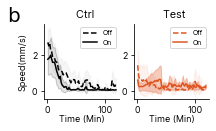

In [109]:
fig1b = plotFormattedTSTransgenic(MB113CLoco,TSTransgenicMetricMapDf, 'V', legendKwargsTSTransgenic, MB113CFilePrefix, figureID = 'Fig1b')


## Contrast plots for metrics in the locomotion object


/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "w_pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent

Saving stats to /Users/xusy/Data/trhcsch1/images/0to24_Contrast_2hr_VFig1cES_Sentences.txt

Fig1c


Bootstrap 1
Test group ("Red Light On; Ctrl", sample size 20) is lower than control group ("Red Light Off; Ctrl", sample size 21) by 0.35 mm/s (95% CI = [-0.8, -0.04] mm/s, p-value = 0.043, g = -0.55).
Hypothesis test used is mann whitney.

Hedge's g for this comparison is -0.55 (95% CI = [-1.02, 0.02] mm/s).


Bootstrap 2
Test group ("Red Light On; Test", sample size 10) is higher than control group ("Red Light Off; Test", sample size 9) by 0.07 mm/s (95% CI = [-0.39, 0.3] mm/s, p-value = 0.391, g = 0.19).
Hypothesis test used is mann whitney.

Hedge's g for this comparison is 0.19 (95% CI = [-0.93, 1.21] mm/s).




/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


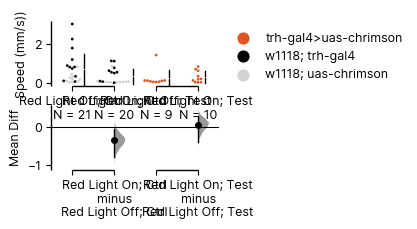

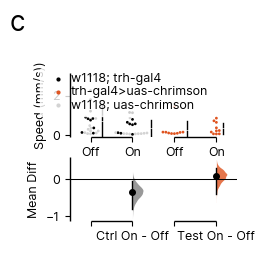

In [111]:
fig1c, contrast1c, summaryResults1c = plotContrast4Columns(MB113CLoco.resultsDf, locoMetricMapDf, 'V', MB113CXlabelsArr, contrastPlotKwargs4Columns, legendKwargs4Columns, MB113CFilePrefix, toAnnotate = True, Cpalette = MB113CLocoPalette, figureID = 'Fig1c')



## Calculate falls

In [112]:
MB113CLoco.calculateFallEvents()



Detecting Fall Events...
Done


In [118]:
locoMetricMapDf

,metric,y,swarmLabel,yUnit
0,V,averageSpeed_mm/s,Speed (mm/s)),mm/s
1,Y,yPosition_mm,Y-Position \n(mm/s),mm
2,InLeftPort,inLeftPort,Percent Time Spent \nin Food Port,%
3,InRightPort,inRightPort,Percent Time Spent \nin Control Port,%


/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "w_pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent

Saving stats to /Users/xusy/Data/trhcsch1/images/0to24_Contrast_2hr_fallsFig1dES_Sentences.txt

Fig1d


Bootstrap 1
Test group ("Red Light On; Ctrl", sample size 20) is lower than control group ("Red Light Off; Ctrl", sample size 21) by 34.05  (95% CI = [-71.88, -11.85] , p-value = 0.044, g = -0.71).
Hypothesis test used is mann whitney.

Hedge's g for this comparison is -0.71 (95% CI = [-1.11, -0.23] ).


Bootstrap 2
Test group ("Red Light On; Test", sample size 10) is higher than control group ("Red Light Off; Test", sample size 9) by 30.51  (95% CI = [-16.61, 79.23] , p-value = 0.712, g = 0.5).
Hypothesis test used is mann whitney.

Hedge's g for this comparison is 0.5 (95% CI = [-0.55, 1.19] ).




/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


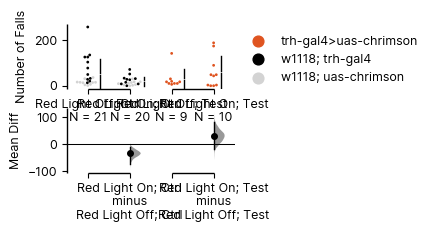

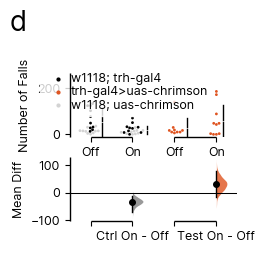

In [120]:
fig1d, contrast1d, summaryResults1d = plotContrast4Columns(MB113CLoco.resultsDf, locoMetricMapDf, 'falls', MB113CXlabelsArr, contrastPlotKwargs4Columns, legendKwargs4Columns, MB113CFilePrefix, toAnnotate = True, Cpalette = MB113CLocoPalette, figureID = 'Fig1d')



Saving stats to /Users/xusy/Data/trhcsch1/output/2 minbeforeAfterSpeedsPairedES_Sentences.txt




Bootstrap 1
Test group ("120afterFeedSpeed_mm/s", sample size 48) is lower than control group ("120beforeFeedSpeed_mm/s", sample size 48) by 0.38  (95% CI = [-0.77, -0.21] , p-value = 0.003, g = -0.23).
Hypothesis test used is paired students.

Hedge's g for this comparison is -0.23 (95% CI = [-0.44, -0.13] ).


Saving stats to /Users/xusy/Data/trhcsch1/output/2 minbeforeDuringSpeedsPairedES_Sentences.txt




Bootstrap 1
Test group ("duringFeedSpeed_mm/s", sample size 48) is lower than control group ("120beforeFeedSpeed_mm/s", sample size 48) by 1.45  (95% CI = [-1.88, -1.05] , p-value = 0.0, g = -1.16).
Hypothesis test used is paired students.

Hedge's g for this comparison is -1.16 (95% CI = [-1.49, -0.89] ).




(                        ChamberID                     countLogID  \
 0    2019-04-29_14-47-32_Chamber1   2019-04-29_14-47-30_Ch1_Obj1   
 1   2019-04-29_14-47-32_Chamber10  2019-04-29_14-47-30_Ch10_Obj1   
 2   2019-04-29_14-47-32_Chamber11  2019-04-29_14-47-30_Ch11_Obj1   
 3   2019-04-29_14-47-32_Chamber12  2019-04-29_14-47-30_Ch12_Obj1   
 4   2019-04-29_14-47-32_Chamber13  2019-04-29_14-47-30_Ch13_Obj1   
 5   2019-04-29_14-47-32_Chamber14  2019-04-29_14-47-30_Ch14_Obj1   
 6   2019-04-29_14-47-32_Chamber15  2019-04-29_14-47-30_Ch15_Obj1   
 7   2019-04-29_14-47-32_Chamber16  2019-04-29_14-47-30_Ch16_Obj1   
 8   2019-04-29_14-47-32_Chamber17  2019-04-29_14-47-30_Ch17_Obj1   
 9   2019-04-29_14-47-32_Chamber18  2019-04-29_14-47-30_Ch18_Obj1   
 10  2019-04-29_14-47-32_Chamber19  2019-04-29_14-47-30_Ch19_Obj1   
 11   2019-04-29_14-47-32_Chamber2   2019-04-29_14-47-30_Ch2_Obj1   
 12  2019-04-29_14-47-32_Chamber20  2019-04-29_14-47-30_Ch20_Obj1   
 13  2019-04-29_14-47-32_Chamber21

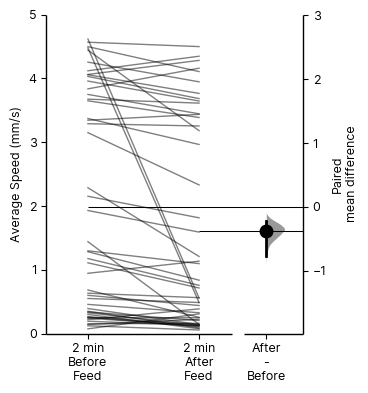

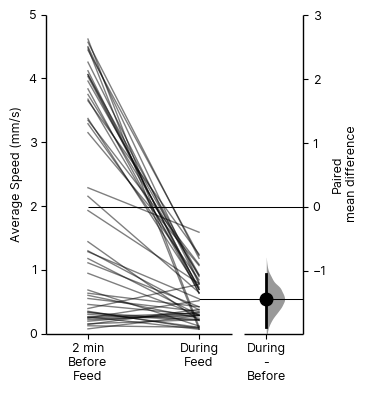

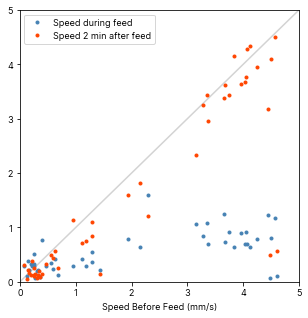

In [121]:

MB113CLoco.plotPeriFeedSpeed(MB113CFeeds, monitorWindow = monitorWindow)

In [ ]:
MB113CLoco.resultsDf.columns

In [122]:
MB113CLoco.resultsDf['duringBeforeSpeedRatio']= MB113CLoco.resultsDf['duringFeedSpeed_mm/s_Mean']/MB113CLoco.resultsDf[str(monitorWindow)+'beforeFeedSpeed_mm/s_Mean']
MB113CLoco.resultsDf['afterBeforeSpeedRatio']= MB113CLoco.resultsDf[str(monitorWindow)+'afterFeedSpeed_mm/s_Mean']/  MB113CLoco.resultsDf[str(monitorWindow)+'beforeFeedSpeed_mm/s_Mean']



## Figure Trh Panel n: Percent gain in speed during feed


/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "w_pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent

Saving stats to /Users/xusy/Data/trhcsch1/images/0to24_Contrast_2hr_DuringRatioFig1cES_Sentences.txt

Fig1c


Bootstrap 1
Test group ("Red Light On; Ctrl", sample size 15) is higher than control group ("Red Light Off; Ctrl", sample size 19) by 0.28  (95% CI = [-0.3, 0.71] , p-value = 0.349, g = 0.35).
Hypothesis test used is mann whitney.

Hedge's g for this comparison is 0.35 (95% CI = [-0.44, 1.1] ).


Bootstrap 2
Test group ("Red Light On; Test", sample size 5) is lower than control group ("Red Light Off; Test", sample size 9) by 0.04  (95% CI = [-0.66, 0.5] , p-value = 0.594, g = -0.05).
Hypothesis test used is mann whitney.

Hedge's g for this comparison is -0.05 (95% CI = [-0.82, 1.64] ).




(<Figure size 216.535x196.85 with 2 Axes>,
 DABEST v0.3.1
              
 Good afternoon!
 The current time is Wed Feb 23 17:41:52 2022.
 
 Effect size(s) with 95% confidence intervals will be computed for:
 1. Red Light On; Ctrl minus Red Light Off; Ctrl
 2. Red Light On; Test minus Red Light Off; Test
 
 5000 resamples will be used to generate the effect size bootstraps.,
   comparison_number              control                test  control_N  \
 0           Fig1c_0  Red Light Off; Ctrl  Red Light On; Ctrl         19   
 1           Fig1c_1  Red Light Off; Test  Red Light On; Test          9   
 
    test_N  difference_MD  ci_MD  bca_low_MD  bca_high_MD bca_interval_idx_MD  \
 0      15           0.28     95       -0.30         0.71          (77, 4812)   
 1       5          -0.04     95       -0.66         0.50         (104, 4850)   
 
    ...  pct_high_HG  pct_interval_idx_HG pvalue_permutation  \
 0  ...         1.33          (125, 4875)               0.33   
 1  ...         1.71

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


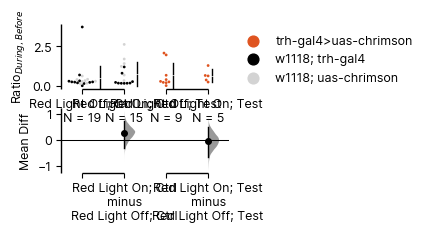

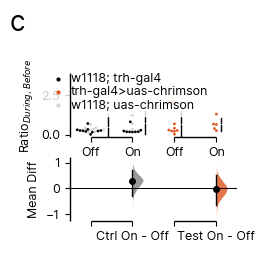

In [124]:

plotContrast4Columns(MB113CLoco.resultsDf, periMetricMapDf, 'DuringRatio', MB113CXlabelsArr, contrastPlotKwargs4Columns, legendKwargs4Columns, MB113CFilePrefix, toAnnotate = True, Cpalette = MB113CLocoPalette, figureID = 'Fig1c')




## Figure Trh Panel n: Percent gain in speed after feed



/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "w_pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent

Saving stats to /Users/xusy/Data/trhcsch1/images/0to24_Contrast_2hr_AfterRatioFig1cES_Sentences.txt

Fig1c


Bootstrap 1
Test group ("Red Light On; Ctrl", sample size 15) is lower than control group ("Red Light Off; Ctrl", sample size 19) by 0.13  (95% CI = [-0.77, 0.15] , p-value = 0.972, g = -0.19).
Hypothesis test used is mann whitney.

Hedge's g for this comparison is -0.19 (95% CI = [-0.78, 0.48] ).


Bootstrap 2
Test group ("Red Light On; Test", sample size 5) is higher than control group ("Red Light Off; Test", sample size 9) by 0.39  (95% CI = [0.07, 0.95] , p-value = 0.11, g = 1.0).
Hypothesis test used is mann whitney.

Hedge's g for this comparison is 1.0 (95% CI = [0.04, 2.02] ).




(<Figure size 216.535x196.85 with 2 Axes>,
 DABEST v0.3.1
              
 Good afternoon!
 The current time is Wed Feb 23 17:42:35 2022.
 
 Effect size(s) with 95% confidence intervals will be computed for:
 1. Red Light On; Ctrl minus Red Light Off; Ctrl
 2. Red Light On; Test minus Red Light Off; Test
 
 5000 resamples will be used to generate the effect size bootstraps.,
   comparison_number              control                test  control_N  \
 0           Fig1c_0  Red Light Off; Ctrl  Red Light On; Ctrl         19   
 1           Fig1c_1  Red Light Off; Test  Red Light On; Test          9   
 
    test_N  difference_MD  ci_MD  bca_low_MD  bca_high_MD bca_interval_idx_MD  \
 0      15          -0.13     95       -0.77         0.15          (21, 4663)   
 1       5           0.39     95        0.07         0.95         (255, 4960)   
 
    ...  pct_high_HG  pct_interval_idx_HG pvalue_permutation  \
 0  ...         0.63          (125, 4875)               0.72   
 1  ...         2.15

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


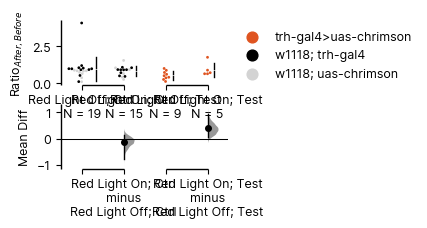

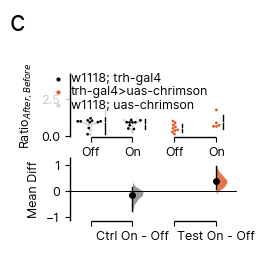

In [125]:


plotContrast4Columns(MB113CLoco.resultsDf, periMetricMapDf, 'AfterRatio', MB113CXlabelsArr, contrastPlotKwargs4Columns, legendKwargs4Columns, MB113CFilePrefix, toAnnotate = True, Cpalette = MB113CLocoPalette, figureID = 'Fig1c')




## Figure Trh Panel q: Contrast for Duration (Revised)

/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent=False, bbox_inches='tight', dpi=fDPI, pad=0.1, w_pad=0.5, h_pad=1.0)
/Users/xusy/Documents/GitHub/SangyuTest/EspressoLocomotion012022/plotTools.py:76: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "w_pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  figure.savefig(fileName +figureID +'.png',transparent

Saving stats to /Users/xusy/Data/trhcsch1/images/0to24_Contrast_2hr_TotalFeedDurationFig1cES_Sentences.txt

Fig1c


Bootstrap 1
Test group ("Red Light On; Ctrl", sample size 20) is lower than control group ("Red Light Off; Ctrl", sample size 21) by 3.62 Seconds (95% CI = [-36.4, 32.75] Seconds, p-value = 0.804, g = -0.06).
Hypothesis test used is mann whitney.

Hedge's g for this comparison is -0.06 (95% CI = [-0.68, 0.6] Seconds).


Bootstrap 2
Test group ("Red Light On; Test", sample size 10) is lower than control group ("Red Light Off; Test", sample size 9) by 9.24 Seconds (95% CI = [-61.15, 78.34] Seconds, p-value = 0.149, g = -0.11).
Hypothesis test used is mann whitney.

Hedge's g for this comparison is -0.11 (95% CI = [-1.19, 0.85] Seconds).




(<Figure size 216.535x196.85 with 2 Axes>,
 DABEST v0.3.1
              
 Good afternoon!
 The current time is Wed Feb 23 17:42:59 2022.
 
 Effect size(s) with 95% confidence intervals will be computed for:
 1. Red Light On; Ctrl minus Red Light Off; Ctrl
 2. Red Light On; Test minus Red Light Off; Test
 
 5000 resamples will be used to generate the effect size bootstraps.,
   comparison_number              control                test  control_N  \
 0           Fig1c_0  Red Light Off; Ctrl  Red Light On; Ctrl         21   
 1           Fig1c_1  Red Light Off; Test  Red Light On; Test          9   
 
    test_N  difference_MD  ci_MD  bca_low_MD  bca_high_MD bca_interval_idx_MD  \
 0      20          -3.62     95      -36.40        32.75         (156, 4902)   
 1      10          -9.24     95      -61.15        78.34         (269, 4959)   
 
    ...  pct_high_HG  pct_interval_idx_HG pvalue_permutation  \
 0  ...         0.54          (125, 4875)               0.84   
 1  ...         0.61

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


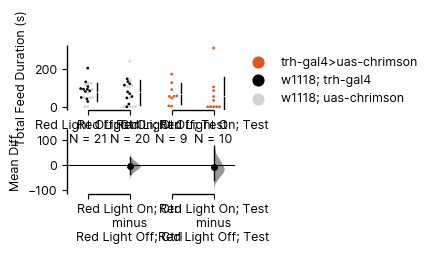

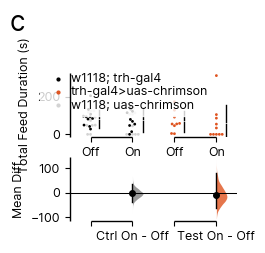

In [126]:

plotContrast4Columns(MB113CLoco.resultsDf, periMetricMapDf, 'TotalFeedDuration', MB113CXlabelsArr, contrastPlotKwargs4Columns, legendKwargs4Columns, MB113CFilePrefix, toAnnotate = True, Cpalette = MB113CLocoPalette, figureID = 'Fig1c')

